# GIS module

GIS operations are integral to hydrology processes. This page demonstrates how to use `xhydro` to perform GIS manipulations such as delineating watershed boundaries and extracting physiographic, climatological and geographical variables at the watershed scale.

In [2]:
import leafmap
import pandas as pd
import xarray as xr
import xclim
import xdatasets as xd
from IPython.core.display import HTML, display

import xhydro.gis as xhgis
from xhydro.indicators import get_yearly_op

## Watershed delineation

Currently, watershed delineation uses HydroBASINS (hybas_na_lev01-12_v1c) and can work in any location in North America. The process involves assessing all upstream sub-basins from a specified outlet and consolidating them into a unified watershed. The [leafmap](https://leafmap.org/) library is employed for generating interactive maps. This map serves the purpose of selecting outlets or visualizing the resulting watershed boundaries. Although utilizing the map is not essential for conducting the calculations, it proves useful for visualization purposes.

In [3]:
m = leafmap.Map(center=(48.63, -74.71), zoom=5, basemap="USGS Hydrography")
m

Map(center=[48.63, -74.71], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

### a) From a list of coordinates
In this scenario, we select two pour points, with each one representing the outlet for the watersheds of Lac Saint-Jean and the Ottawa River, respectively.

In [4]:
lng_lat = [
    (-69.81971, 48.14720),  # Lac Saint-Jean watershed
    (-74.393438, 45.572442),  # Ottawa river watershed
]

### b) From markers on a map

Instead of using a list, a more interactive approach is to directly select outlets from the existing map ``m``. The following image illustrates the process of selecting pour points by dragging markers to the desired locations on the map.

![test](../../docs/_static/_images/example_draw_marker.png)

The next cell is only useful for the documentation as it simulates a user selecting an outlet from the map `m`. You should instead remove this code and interact with the map in object `m` as shown above by positioning markers at sites of interest

In [5]:
m.draw_features = [
    {
        "type": "Feature",
        "properties": {},
        "geometry": {"type": "Point", "coordinates": [-73.118597, 46.042467]},
    }
]  # Richelieu watershed

After selecting points using either approach a) or b), or a combination of both, we can initiate the watershed delineation calculation.

In [6]:
gdf = xhgis.watershed_delineation(coordinates=lng_lat, map=m)
gdf

,HYBAS_ID,Upstream Area (sq. km).,geometry,category,color
0,7120034330,87595.8,"POLYGON ((-74.37864 48.88141, -74.37452 48.886...",1,#ffffd9
1,7120034330,87595.8,"POLYGON ((-74.33808 49.28658, -74.34388 49.288...",1,#ffffd9
2,7120034330,87595.8,"POLYGON ((-74.38747 49.38815, -74.38578 49.386...",1,#ffffd9
3,7120398781,144026.8,"POLYGON ((-80.07991 46.7786, -80.08529 46.7827...",2,#c7e9b4
4,7120398781,144026.8,"POLYGON ((-78.59583 45.475, -78.59675 45.46602...",2,#c7e9b4
5,7120382860,23717.7,"POLYGON ((-73.77437 43.36757, -73.77557 43.388...",1,#ffffd9


The outcomes are stored in a GeoPandas `gpd.GeoDataFrame` (`gdf`) object, allowing us to save our polygons in various common formats such as an ESRI Shapefile or GeoJSON. If a map ``m`` is present, the polygons will automatically be added to it. If you want to visualize the map, simply type ``m`` in the code cell to render it. If displaying the map directly is not compatible with your notebook interpreter, you can utilize the following code to extract the HTML from the map and plot it:

In [7]:
m.zoom_to_gdf(gdf)

### c) From [xdatasets](https://github.com/hydrologie/xdatasets)

Automatically delineating watershed boundaries is a valuable tool in the toolbox, but users are encouraged to utilize official watershed boundaries if they already exist, instead of creating new ones. This functionality fetches a list of basins from [xdatasets](https://github.com/hydrologie/xdatasets) supported datasets, and upon request, [xdatasets](https://github.com/hydrologie/xdatasets) provides a `gpd.GeoDataFrame` containing the precalculated boundaries for these basins. Currently, the following watershed sources are available as of today.:

| Source                                                                                                                                                             | Dataset name   |
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| [DEH](https://www.cehq.gouv.qc.ca/atlas-hydroclimatique/stations-hydrometriques/index.htm)                                                                         | deh_polygons   |
| [HYDAT](https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/national-archive-hydat.html) | hydat_polygons |
| [HQ](https://www.hydroquebec.com/r)                                                                                                                                | hq_polygons    |


In [8]:
gdf = xd.Query(
    **{
        "datasets": {
            "deh_polygons": {
                "id": ["031*", "0421*"],
                "regulated": ["Natural"],
            }
        }
    }
).data.reset_index()

gdf

,Station,Superficie,geometry
0,031501,21.868620,"POLYGON ((-72.47379 46.2334, -72.46888 46.2287..."
1,031502,15.708960,"POLYGON ((-72.50126 46.21216, -72.50086 46.213..."
2,042103,579.479614,"POLYGON ((-78.49014 46.64514, -78.4901 46.6450..."


## Extract watershed properties

After obtaining our watershed boundaries, we can extract valuable properties such as geographical information, land use classification and climatological data from the delineated watersheds.

### a) Geographical watershed properties
Initially, we extract geographical properties of the watershed, including the perimeter, total area, Gravelius coefficient and basin centroid. It's important to note that this function returns all the columns present in the provided `gpd.GeoDataFrame` argument.

In [9]:
xhgis.watershed_properties(gdf)

,Station,Superficie,area,perimeter,gravelius,centroid
0,031501,21.868620,2.186862e+07,27186.996845,1.640007,"(-72.48631199105834, 46.22277542928622)"
1,031502,15.708960,1.570896e+07,20263.293021,1.442220,"(-72.47966677792694, 46.21359517038631)"
2,042103,579.479614,5.794796e+08,283765.058390,3.325331,"(-78.37036445281987, 46.48287117609677)"


For added convenience, we can also retrieve the same results in the form of an `xarray.Dataset`:

In [10]:
xhgis.watershed_properties(
    gdf[["Station", "geometry"]], unique_id="Station", output_format="xarray"
)

<xarray.Dataset> Size: 120B
Dimensions:    (Station: 3)
Coordinates:
  * Station    (Station) object 24B '031501' '031502' '042103'
Data variables:
    area       (Station) float64 24B 2.187e+07 1.571e+07 5.795e+08
    perimeter  (Station) float64 24B 2.719e+04 2.026e+04 2.838e+05
    gravelius  (Station) float64 24B 1.64 1.442 3.325
    centroid   (Station) object 24B (-72.48631199105834, 46.22277542928622) ....

We can also extract the surface properties for the same `gpd.GeoDataFrame` : 

In [11]:
xhgis.surface_properties(gdf)

,elevation,slope,aspect,proj:epsg,band,proj:shape,time,gsd,platform,epsg,spatial_ref
geometry,,,,,,,,,,,
0,33.573009,0.324613,239.025970,4326,data,{1200},2021-04-22,90,TanDEM-X,4326,0
1,51.393295,0.518484,242.431320,4326,data,{1200},2021-04-22,90,TanDEM-X,4326,0
2,358.549866,2.500644,178.557648,4326,data,{1200},2021-04-22,90,TanDEM-X,4326,0


Again, for convenience, we can output the results in `xarray.Dataset` format : 

In [12]:
xhgis.surface_properties(
    gdf[["Station", "geometry"]], output_format="xarray", unique_id="Station"
)

<xarray.Dataset> Size: 164B
Dimensions:      (Station: 3)
Coordinates:
    proj:epsg    int32 4B 4326
    band         <U4 16B 'data'
    proj:shape   object 8B {1200}
    time         datetime64[ns] 8B 2021-04-22
    gsd          int32 4B 90
    platform     <U8 32B 'TanDEM-X'
    epsg         int32 4B 4326
    spatial_ref  int32 4B 0
    geometry     (Station) object 24B POLYGON ((-306224.9316606918 257197.438...
  * Station      (Station) object 24B '031501' '031502' '042103'
Data variables:
    elevation    (Station) float32 12B 33.57 51.39 358.5
    slope        (Station) float32 12B 0.3246 0.5185 2.501
    aspect       (Station) float32 12B 239.0 242.4 178.6
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-79.00083333333333, 46.0, -72....
    resolution:  0.0008333333333333334
    _FillValue:  nan

### b) Land-use classification
Land use classification is powered by the Planetary Computer's STAC catalog. It uses the `10m Annual Land Use Land Cover` dataset by default ("io-lulc-annual-v02"), but other collections can be specified by using the collection argument. 

In [13]:
df = xhgis.land_use_classification(gdf, unique_id="Station", output_format="xarray")
df

  0%|          | 0/3 [00:00<?, ?it/s]

<xarray.Dataset> Size: 192B
Dimensions:                 (Station: 3)
Coordinates:
  * Station                 (Station) object 24B '031501' '031502' '042103'
Data variables:
    pct_built_area          (Station) float64 24B 0.01544 0.01 1.618e-05
    pct_crops               (Station) float64 24B 0.7167 0.6625 0.0
    pct_trees               (Station) float64 24B 0.2594 0.3158 0.9093
    pct_rangeland           (Station) float64 24B 0.00841 0.01171 0.004853
    pct_water               (Station) float64 24B 0.0 0.0 0.08544
    pct_flooded_vegetation  (Station) float64 24B 0.0 0.0 0.0004165
    pct_bare_ground         (Station) float64 24B 0.0 0.0 3.614e-06
Attributes:
    year:                2023
    collection:          io-lulc-annual-v02
    spatial_resolution:  10

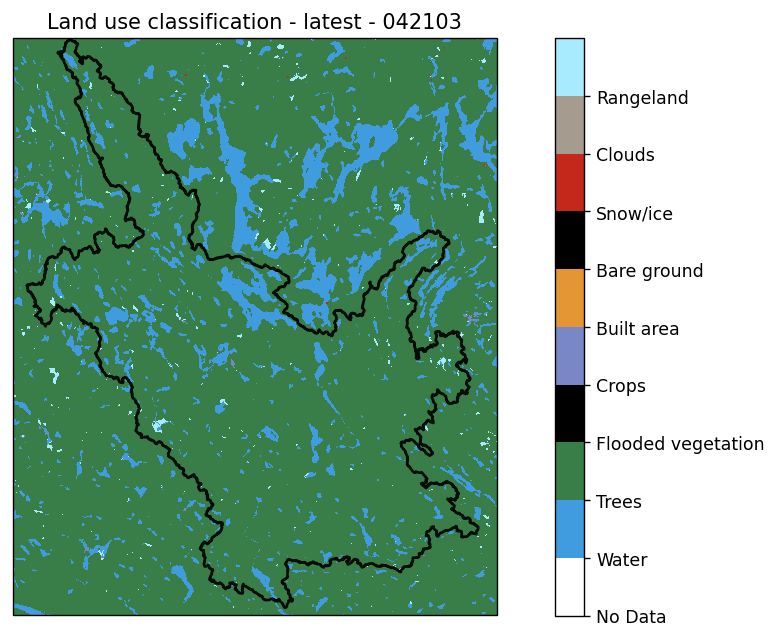

In [14]:
ax = xhgis.land_use_plot(gdf, unique_id="Station", idx=2)

### c) Climate indicators
The step of extracting climatic indicators is the most complex. Indeed, to accomplish this, access to a weather dataset for the various watersheds within our `gdf` object is required. Fortunately, `xdatasets` precisely facilitates such operations. Indeed, `xdatasets` allows extracting from a gridded dataset all the pixels contained within a watershed while respecting the weighting of the watershed intersecting each pixel.Subsequently, the function `get_yearly_op`, built upon the `xclim` library, offers impressive flexibility in defining indicators tailored to the user's needs.

To initiate the process, we employ ERA5-Land reanalysis data spanning the period from 1981 to 2010 as our climatological dataset.

In [15]:
datasets = {
    "era5_land_reanalysis": {"variables": ["t2m", "tp", "sd"]},
}
space = {
    "clip": "polygon",  # bbox, point or polygon
    "averaging": True,
    "geometry": gdf.iloc[0:2],  # select the 2 first polygons
    "unique_id": "Station",
}
time = {
    "start": "1981-01-01",
    "end": "2010-12-31",
    "timezone": "America/Montreal",
}

ds = xd.Query(datasets=datasets, space=space, time=time).data.squeeze()

0it [00:00, ?it/s]

Because the next few steps use [xclim](https://xclim.readthedocs.io/en/stable/index.html) under the hood, the dataset is required to be [CF-compliant](http://cfconventions.org/cf-conventions/cf-conventions.html). At a minimum, the `xarray.DataArray` used must follow these principles:

- The dataset needs a time dimension, usually at a daily frequency with no missing timesteps (NaNs are supported). If your data differs from that, you'll need to be extra careful on the results provided.
- If there is a spatial dimension, such as "``Station``" in the example below, it needs an attribute ``cf_role`` with ``timeseries_id`` as its value.
- The variable will at the very least need a ``units`` attribute, although other attributes such as ``long_name`` and ``cell_methods`` are also expected by `xclim` and warnings will be generated if they are missing.
- While this is not necessary for get_yearly_op, variable names should be one of those supported here for maximum compatibility.

The following code adds the missing attributes :

In [16]:
ds = ds.rename({"t2m": "tas", "tp": "pr", "sd": "snd"})
ds["tas"] = xclim.core.units.convert_units_to(
    ds["tas"], "degC"
)  # Convert from degK to degC
ds["tas"].attrs.update({"cell_methods": "time: mean"})

ds["pr"].attrs.update({"units": "m d-1", "cell_methods": "time: mean within days"})
ds["pr"] = xclim.core.units.convert_units_to(
    ds["pr"], "mm d-1"
)  # Convert from m/d to mm/d

ds["snd"].attrs.update({"units": "m", "cell_methods": "time: mean within days"})
ds["snd"] = xclim.core.units.convert_units_to(ds["snd"], "mm")  # Convert from m to mm
ds

<xarray.Dataset> Size: 15MB
Dimensions:  (Station: 2, time: 262968)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1981-01-01 ... 2010-12-31T23:00:00
  * Station  (Station) object 16B '031501' '031502'
    source   <U20 80B 'era5_land_reanalysis'
Data variables:
    tas      (Station, time) float64 4MB -23.29 -23.28 -23.49 ... 2.734 2.454
    pr       (Station, time) float64 4MB 0.0 0.0 0.0 ... 0.01582 0.3079 1.186
    snd      (Station, time) float64 4MB 55.07 55.07 55.07 ... 35.57 35.27 35.01

In the second step, we can define seasons using indexers that are compatible with ``xclim.core.calendar.select_time``. There are currently four accepted types of indexers:

- `month`, followed by a sequence of month numbers.

- `season`, followed by one or more of `‘DJF’`, `‘MAM’`, `‘JJA’`, and `‘SON’`.

- `doy_bounds`, followed by a sequence representing the inclusive bounds of the period to be considered (`'start'`, `'end'`).

- `date_bounds`, which is the same as above, but using a month-day (`'%m-%d'`) format.

Following this, we specify the operations we intend to calculate for each variable. The supported operations include `"max"`, `"min"`, `"mean"`, and `"sum"`.

In [17]:
timeargs = {
    "01": {"month": [1]},
    "02": {"month": [2]},
    "03": {"month": [3]},
    "04": {"month": [4]},
    "05": {"month": [5]},
    "06": {"month": [6]},
    "07": {"month": [7]},
    "08": {"month": [8]},
    "09": {"month": [9]},
    "10": {"month": [10]},
    "11": {"month": [11]},
    "12": {"month": [12]},
    "spring": {"date_bounds": ["02-11", "06-19"]},
    "summer_fall": {"date_bounds": ["06-20", "11-19"]},
    "year": {"date_bounds": ["01-01", "12-31"]},
}

operations = {
    "tas": ["max", "mean", "min"],
    "pr": ["sum"],
    "snd": ["mean"],
}

The combination of `timeargs` and `operations` through the Cartesian product yields a rapid generation of an extensive array of climate indicators.

In [18]:
ds_climatology = xr.merge(
    [
        get_yearly_op(ds, input_var=variable, op=op, timeargs=timeargs)
        for (variable, ops) in operations.items()
        for op in ops
    ]
)
ds_climatology

<xarray.Dataset> Size: 36kB
Dimensions:               (Station: 2, time: 30)
Coordinates:
  * Station               (Station) object 16B '031501' '031502'
    source                <U20 80B 'era5_land_reanalysis'
  * time                  (time) datetime64[ns] 240B 1981-01-01 ... 2010-01-01
Data variables: (12/75)
    tas_max_01            (Station, time) float64 480B 5.1 3.616 ... 9.685
    tas_max_02            (Station, time) float64 480B 13.23 1.781 ... 5.404
    tas_max_03            (Station, time) float64 480B 11.61 10.72 ... 11.53
    tas_max_04            (Station, time) float64 480B 19.4 20.66 ... 25.72 25.3
    tas_max_05            (Station, time) float64 480B 24.39 28.17 ... 31.67
    tas_max_06            (Station, time) float64 480B 29.32 28.33 ... 28.63
    ...                    ...
    snd_mean_10           (Station, time) float64 480B 0.3611 ... 0.0389
    snd_mean_11           (Station, time) float64 480B 4.29 2.369 ... 2.396
    snd_mean_12           (Station, time) float64 480B 44.07 5.757 ... 29.87
    snd_mean_spring       (Station, time) float64 480B 6.949 92.08 ... 16.39
    snd_mean_summer_fall  (Station, time) float64 480B 0.1345 0.1227 ... 0.03939
    snd_mean_year         (Station, time) float64 480B 14.36 47.45 ... 15.62
Attributes:
    cat:variable:          ('tas_max_01',)
    cat:xrfreq:            YS-JAN
    cat:frequency:         yr
    cat:processing_level:  indicators
    cat:id:

The same data can also be visualized as a `pd.DataFrame` as well : 

In [19]:
pd.set_option("display.max_rows", 100)
ds_climatology.mean("time").to_dataframe().T

Station,031501,031502
source,era5_land_reanalysis,era5_land_reanalysis
tas_max_01,5.79328,5.83979
tas_max_02,5.709544,5.74949
tas_max_03,12.451726,12.531728
tas_max_04,21.224634,21.254693
tas_max_05,26.618743,26.62262
tas_max_06,29.915254,29.914234
tas_max_07,30.538177,30.541674
tas_max_08,29.401676,29.396607
tas_max_09,26.409743,26.420074
